In [24]:
import pickle
import hddCRP.behaviorDataHandlers
import matplotlib.pyplot as plt
import numpy as np
import os

In [25]:

context_length = 2;
num_runs = 1;
runs = range(num_runs);
num_warmup_samples = 5000
num_samples        = 20000
overwrite_existing_results = False

binarize_choices = True;

num_sessions = 1;
num_sessions_str = str(num_sessions) if num_sessions > 1 else '';

simple_model = False
single_concentration = False
sequential_distances_only = True # if false, model setup more as a "smoother". If true, can simulate from the model

if(sequential_distances_only):
    results_directory = "Results/Pop" + num_sessions_str + "/sequentialModel/"
else:
    results_directory = "Results/Pop" + num_sessions_str + "/"

if(binarize_choices):
    results_directory += "binary/"


if(simple_model):
    results_directory += "simple/"
elif(single_concentration):
    results_directory += "singleAlpha/"

if(not os.path.exists(results_directory)):
    os.makedirs(results_directory)

data_filename = 'data/Data_turns_all_by_session.pkl';
with open(data_filename, 'rb') as data_file:
    data = pickle.load(data_file)

subjects_0 = list(data["data"].keys())





cc = 1;
prior_scales = None;#{"alpha" : 5/cc, "tau_within" : 25, "tau_between" : 5}
prior_shapes = None;#{"alpha" : 2*cc, "tau_within" :  2, "tau_between" : 2}

group_names = np.array(["all", "uniform", "diverse"])


In [26]:
for subs in [1,2]:
    # subjects = ["A1"] subs = 2;
    # if(subs != 0):
    #     subjects_id = np.array([True if xx.endswith(str(subs)) else False for xx in subjects_0])
    #     subjects = np.array(subjects_0)
    #     subjects = subjects[subjects_id]
    # else:
    #     subjects = subjects_0

    if(subs == 0):
        subjects = subjects_0;
    else:
        subjects = data["group_definition"][group_names[subs]]

    subjects.sort()
    print("subjects = " + str(subjects))
    for run_idx in runs:
        print(f"RUN {run_idx}")
        filename = "{results_directory}/Subs_{subs}_context_{context_length}_run_{run_idx}.pkl".format(subs=subs, results_directory=results_directory, run_idx=run_idx, context_length=context_length)
        print(filename)
        if(not os.path.isfile(filename) or overwrite_existing_results):
            # for each run, should do some randomization of initial parameters (with known seeds so we can repeat everything)

            seed = subs * 1000 + run_idx;
            rng = np.random.Generator(np.random.MT19937(seed))

            models = [];
            for subject_idx, subject in enumerate(subjects):
                sequences = data["data"][subject]["data"]; # turns in each session
                session_types = data["data"][subject]["task"] # which maze

                ii = session_types.index("C")
                sequences = sequences[ii:ii+num_sessions].copy()
                session_types = session_types[ii:ii+num_sessions]

                if(binarize_choices):
                    for seq in sequences:
                        for ii, ss in enumerate(seq):
                            if((data["turn_definition"][ss].upper().startswith("L")) or (data["turn_definition"][ss].upper().startswith("R"))):
                                seq[ii] = 3

                model = hddCRP.behaviorDataHandlers.create_hddCRP(sequences, session_types, rng = rng, 
                        sequential_distances_only=sequential_distances_only, depth=(context_length+1), include_timescales=(not simple_model))
                models += [model]
            tau_names = [str(xx) for xx in models[0].weight_param_labels]

            alphas_names = ["alpha_concentration_no_context", "alpha_concentration_one_back_context", "alpha_concentration_two_back_context"]
            alphas_names = alphas_names[:(context_length+1)]
            models, samples, step_size_settings = hddCRP.behaviorDataHandlers.sample_population_model_for_maze_data(models, num_samples=num_samples, num_warmup_samples=num_warmup_samples, 
                print_every=2500, single_concentration_parameter=single_concentration,  prior_shapes=prior_shapes, prior_scales=prior_scales)
        
            MCMC_info = {"step_size_settings" : step_size_settings.to_dict(),
                        "num_warmup_samples" : num_warmup_samples,
                        "num_samples" : num_samples,
                        "seed" : seed, 
                        "sequential_distances_only" : sequential_distances_only, 
                        "binarize_choices" : binarize_choices}
            samples["tau_parameter_names"] = tau_names
            samples["alphas_names"] = alphas_names
            samples["stats"] = [{"subject" : subjects[ii], "contexts" : models[ii]._groupings, "observations" : models[ii]._Y} for ii in range(len(subjects))]
            
            # save results to filename
            with open(filename, "wb") as results_file:
                results_data = {"MCMC_info" : MCMC_info,
                                "samples" : samples}
                pickle.dump(results_data, results_file)
                print("saved")

subjects = ['A1', 'B1', 'C1', 'D1', 'E1', 'F1', 'G1', 'H1', 'I1', 'J1']
RUN 0
Results/Pop/sequentialModel/binary//Subs_1_context_2_run_0.pkl
Sample 0 / 25000
Sample 2500 / 25000
Sample 5000 / 25000
Sample 7500 / 25000
Sample 10000 / 25000
Sample 12500 / 25000
Sample 15000 / 25000
Sample 17500 / 25000
Sample 20000 / 25000
Sample 22500 / 25000
saved
subjects = ['A2', 'B2', 'C2', 'D2', 'E2', 'F2', 'G2', 'I2', 'J2']
RUN 0
Results/Pop/sequentialModel/binary//Subs_2_context_2_run_0.pkl
Sample 0 / 25000
Sample 2500 / 25000
Sample 5000 / 25000
Sample 7500 / 25000
Sample 10000 / 25000
Sample 12500 / 25000
Sample 15000 / 25000
Sample 17500 / 25000
Sample 20000 / 25000
Sample 22500 / 25000
saved


In [27]:
alphas_names = ["alpha_concentration_no_context", "alpha_concentration_one_back_context", "alpha_concentration_two_back_context"]
alphas_names = alphas_names[:(context_length+1)]

In [28]:

taus = np.zeros((num_samples,min(2,num_sessions),len(runs),3))
alphas = np.zeros((num_samples,context_length+1,len(runs),3))

for run_idx in runs:
    for subs_idx, subs in enumerate([0,1,2]):
        filename = "{results_directory}/Subs_{subs}_context_{context_length}_run_{run_idx}.pkl".format(subs=subs, results_directory=results_directory, run_idx=run_idx, context_length=context_length)
        if(os.path.exists(filename)):
            with open(filename, "rb") as file:
                results = pickle.load(file)

                ss = range(results["MCMC_info"]["num_warmup_samples"], results["MCMC_info"]["num_warmup_samples"]+results["MCMC_info"]["num_samples"])
                taus[:,:,run_idx,subs_idx] = np.exp(results["samples"]["log_taus"][ss,:])
                alphas[:,:,run_idx,subs_idx] = results["samples"]["alphas"][ss,:]


In [29]:
# compute these from predictive distributions
# p(straight or turn|turn)
# p(turn or straight | straight)

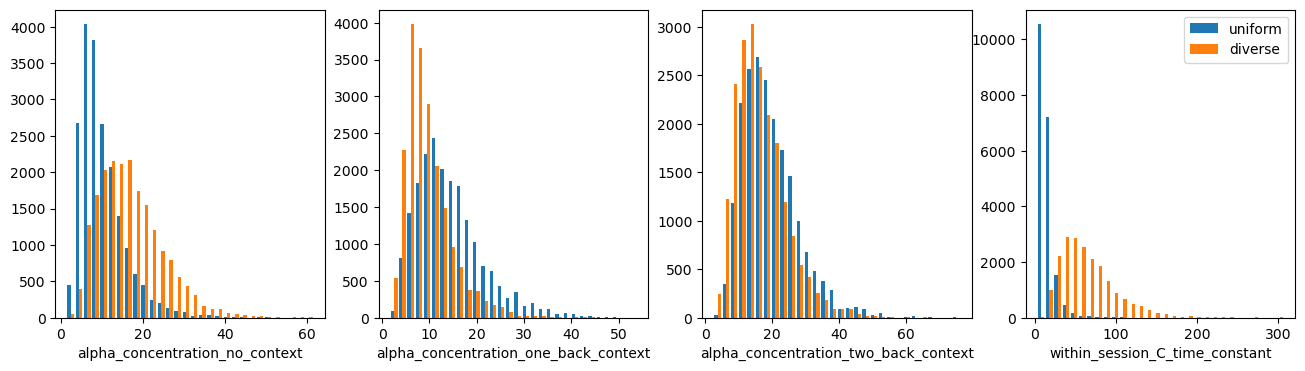

In [30]:
rr = np.array([1,2])
run_idx = 0;
T = taus.shape[1]
plt.figure(figsize=((3+T)*4,4))
for ii in range(alphas.shape[1]):
    plt.subplot(1,3+T,ii+1)
    plt.hist(np.squeeze(alphas[:,ii,run_idx,rr]),30)
    plt.xlabel(alphas_names[ii])
for tt in range(T):
    plt.subplot(1,3+T,4+tt)
    plt.hist(np.squeeze(taus[:,tt,run_idx,rr]),30);
    plt.xlabel(samples["tau_parameter_names"][tt])
plt.legend(group_names[rr])


In [31]:
from scipy.stats.mstats import gmean
s1 = 1;
s2 = 2

a2 = alphas[:,:,run_idx,s2];
a1 = alphas[:,:,run_idx,s1];
t2 = taus[:,:,run_idx,s2];
t1 = taus[:,:,run_idx,s1];

# a1[:,0] = a1[:,0] - np.mean(a1[:,1:],axis=1)
# a2[:,0] = a2[:,0] - np.mean(a2[:,1:],axis=1)


# t1 = np.mean(a1,axis=1)
# t2 = np.mean(a2,axis=1)
# t1 = gmean(a1,axis=1)
# t2 = gmean(a2,axis=1)

NA = alphas.shape[1];
a1c = a1.copy()
a2c = a2.copy()
t1c = t1.copy()
t2c = t2.copy()

a1c[:,:] = a1c[np.random.permutation(a1c.shape[0]),:]
a2c[:,:] = a2c[np.random.permutation(a2c.shape[0]),:]
ac = a2c > a1c;
print(np.mean(ac,axis=0))

    
t1c[:,:] = t1c[np.random.permutation(t1c.shape[0]),:]
t2c[:,:] = t2c[np.random.permutation(t2c.shape[0]),:]
print(np.mean(t2c > t1c,axis=0))


[0.77365 0.2687  0.37975]
[0.97675]


In [32]:
data["group_definition"]

{'diverse_TH': ['A2', 'B2', 'C2', 'D2', 'E2'],
 'diverse_HT': ['F2', 'G2', 'I2', 'J2'],
 'uniform_H': ['A1', 'B1', 'C1', 'D1', 'E1'],
 'uniform_T': ['F1', 'G1', 'H1', 'I1', 'J1'],
 'diverse': ['A2', 'B2', 'C2', 'D2', 'E2', 'F2', 'G2', 'I2', 'J2'],
 'uniform': ['A1', 'B1', 'C1', 'D1', 'E1', 'F1', 'G1', 'H1', 'I1', 'J1']}